# San Francisco Fires Intervention
## Simulation course project

The aim of this university project is to apply the main concept trated in the simulation course, in particular  simulating fire burst and fire fighters intervention in San Francisco, California in a given time window.
In this document we resume the data analysis experiment implemented and the final simulation.

We used the ["Fire Incidents"](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric) dataset provided by [San Francisco open data portal](https://datasf.org/). This 454K rows long dataset contain a lot of information (63 varaibles) about fire incident in the city of San Francisco from 2003 to present days.

## Importing package and data cleaning
In the following cell we have imported the python package needed, imported and cleaned the data.
All the date in dataset are strings, to easily manage that values in python we need to convert them in datetime type. Also the "Location" variable is a string so we split it in "Latitude" and "Longitude" variables, both numerical.

Note that the data importation and data cleaning operation can take some execution time. 

In [2]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2
pylab.rcParams['figure.figsize'] = (20, 20)
matplotlib.rcParams['figure.figsize'] = (10,10)

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from simulation_package.exponential import Exponential
from simulation_package.gamma import  Gamma
from simulation_package.normal import Normal
from simulation_package.discrete_events import SFFireSimulation
from scipy.stats import kstest
import scipy
import re

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Importing and cleaning data
def getcoordfstr(location):
    return re.findall(r"[-+]?\d*\.\d+|\d+", location)

df = pd.read_csv("SF_fire_incidents/Fire_Incidents.csv", dtype=object)
df.index = pd.to_datetime(df['Incident Date'], format= "%m/%d/%Y")

# convert date in datetime
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Close DtTm'] = pd.to_datetime(df['Close DtTm'], format= "%m/%d/%Y %I:%M:%S %p")

# convert Location in numerical Latitude and Longitude
df['Latitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[0]) if not pd.isnull(x) else x)
df['Longitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[1]) if not pd.isnull(x) else x)

### Variables exploration and distribution fitting
In this section, as introduced before, we present the analysis made on the data, we highlight the distribution that best fit the real data. Particulary interesting for our purpose are the following variables: 

* Alarm DtTm
* Arrival DtTm
* Close DtTm
* Action Taken Primary
* Action Taken Secondary
* Action Taken Other
* Location (Latitude and Longitude)

We used the first three of that list (Alarm DtTm, Arrival DtTm, Close DtTm) to calculate the fire burst alarm intertime and the intervention time distribution.
We start by define two utility functions to calculate this values, calculate_intertime and calculate_timediff, the firt one calculate the difference between the values of given column in two near rows of the sorted dataframe. The second one, instead, calculate the difference between two column in the same row.

In [4]:
def calculate_intertime(df, column):
    sorted_df = df.sort_values(column)
    delta = ((sorted_df[column]-sorted_df[column].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

def calculate_timediff(df, time_column1, time_column2):
    delta = ((df[time_column2]-df[time_column1].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

## Fire burst intertime

In the next cell we plot the fire burst intertimes and we show that they follow an exponential distribution. Using the maximum likelihood technique we have estimated the $\lambda$ parameter of distribution obtaining:

$$ \hat{\lambda} = \frac{n}{\sum_{i} x_i}  $$

where $\hat{\lambda}$ is an unbiased estimator of $\lambda$.

In the obtained plot we indicate the calculate intertime in the blue histogram, the scypy exponential probability distribution function with the red line and, finally, our implementation of exponantial pdf with green points. 

[ 1310.29204353   263.40141958    71.64632589 ...,  1313.45040483
   896.82962075   253.41263783]
1050.7392199


(0, 10000)

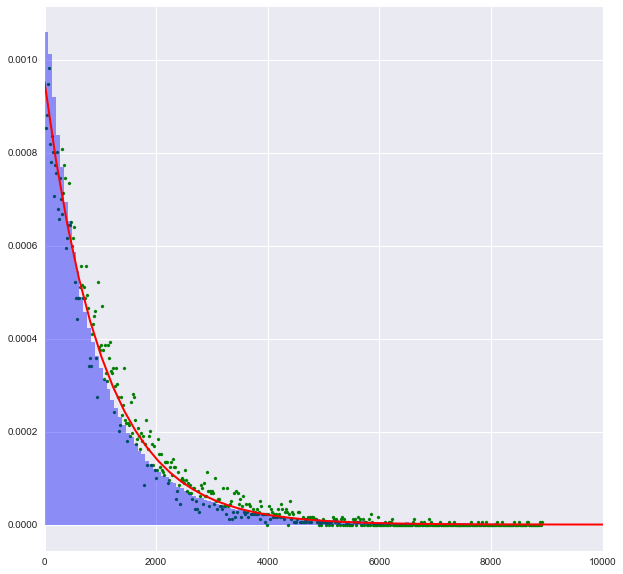

In [11]:
alarm_intertime = calculate_intertime(df, 'Alarm DtTm')

exp_bins, exp_counts = Exponential(1/alarm_intertime.mean()).pdf(10000, 500)
xs = np.linspace(0, 10000)
rv = stats.expon(0,alarm_intertime.mean())
print(alarm_intertime.mean())


f, ax = plt.subplots()
ax.hist(alarm_intertime, bins=500, color="blue", normed=True, lw=1, alpha=0.4)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)
ax.scatter(exp_bins, exp_counts, color="green", lw=0.1, s=10)
ax.set_xlim(0, 10000)

In [12]:
kstest(alarm_intertime, 'expon', args=(0,alarm_intertime.mean()))

KstestResult(statistic=0.043641964521787591, pvalue=0.0)

In [ ]:
x_limit = 30000

serving_times = calculate_timediff(df, 'Arrival DtTm', 'Close DtTm')
serving_times = serving_times[(serving_times > 0) & (serving_times < x_limit)]
print(min(serving_times))
print(max(serving_times))

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    s = np.log(mean) - np.mean(np.log(data))
    shape = (3-s+np.sqrt(((s-3)**2)+24*s))/(12*s)
    scale = mean/shape
    return (shape, 0, scale)

def calculateLognormalParams(data):
    mean = np.mean(np.log(data))
    scale = np.exp(mean)
    shape = np.sqrt(np.mean((np.log(data)-mean)**2))
    return (shape, 0, scale)

print(calculateGammaParams(serving_times))

xs = np.linspace(0, x_limit)
gshape, gloc, gscale = calculateGammaParams(serving_times)

print(serving_times.mean())
rv = stats.gamma.pdf(xs, gshape, gloc, gscale)
print(serving_times.size)
plt.hist(serving_times, bins=150, color="blue", normed=True, lw=1, alpha=0.4)
plt.plot(xs, rv, color="red", lw=2)
plt.show()
plt.clf()

In [ ]:
kstest(serving_times, 'gamma', args=(gshape, gloc, gscale))

In [ ]:
intervention_times = (df['Close DtTm']-df['Alarm DtTm']).fillna(0).apply(lambda x: x.total_seconds()).astype('int64')
print(len(intervention_times))
print(len(intervention_times[intervention_times < 0.0]))

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    s = np.log(mean) - np.mean(np.log(data))
    shape = (3-s+np.sqrt(((s-3)**2)+24*s))/(12*s)
    scale = mean/shape
    return (shape, 0, scale)

def calculateGammaParams2(data):
    mean = np.mean(data)
    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    return (shape, 0, scale)

def calculateLognormalParams(data):
    mean = np.mean(np.log(data))
    scale = np.exp(mean)
    shape = np.sqrt(np.mean((np.log(data)-mean)**2))
    return (shape, 0, scale)

data = intervention_times[(intervention_times > 0.0) & (intervention_times < 8000.0)]
gshape, gloc, gscale = calculateGammaParams2(data)
#print(gshape, gloc, gscale)
nlshape, nlloc, nlscale = calculateLognormalParams(data)

xs = np.linspace(0, 8000)

normal_bm  = Normal(mu=nlshape, sigma=nlscale, t="bm", log=True)
pdf_bm_x, pdf_bm_y = normal_bm.pdf(30000, 150)

ey = stats.gamma.pdf(xs, gshape, gloc, gscale)
b, c = Gamma(int(round(gshape)), 1/gscale).pdf(5000, 150)
nly = stats.lognorm.pdf(xs, nlshape, nlloc, nlscale)
n, bins, patches = plt.hist(data, bins=150, normed=True, alpha=0.3)
plt.plot(xs, ey, color="red")
plt.plot(xs, nly, color="green")
plt.scatter(b,c, color="blue", alpha=0.8, s=5)
plt.scatter(pdf_bm_x, pdf_bm_y, color="black", s=5)

plt.show()
plt.clf()

In [ ]:
box = df['Box']
vc_box = box.value_counts(dropna=True)
idx = vc_box.index
x = range(len(idx))
print(len(idx))
plt.bar(x, vc_box)
plt.xticks(x, idx, rotation=90)
plt.show()

In [ ]:
normal_bm  = Normal(mu=0.0, sigma=0.25, t="bm", log=True)
pdf_bm_x, pdf_bm_y = normal_bm.pdf(30000, 150)

normal_approx = Normal(t="approx", log=False)
pdf_approx_x, pdf_approx_y = normal_approx.pdf(30000, 150)

plt.scatter(pdf_bm_x, pdf_bm_y, color="blue", s=10)
plt.scatter(pdf_approx_x, pdf_approx_y, color="green", s=10)
plt.show()

In [ ]:
civilian_fatalities = df['Number of Sprinkler Heads Operating'].value_counts(normalize=True)
print(civilian_fatalities[civilian_fatalities<300])
plt.bar(civilian_fatalities[civilian_fatalities<300].index.astype('int32'), civilian_fatalities[civilian_fatalities<300], 0.35, color='r')

In [ ]:
x = df['Action Taken Secondary'].value_counts(normalize=True)
#np.random.choice(x.index, 1, p=x)
x

In [ ]:
prop_loss = (df['Estimated Contents Loss'].dropna().astype('float'))
print(max(prop_loss))
print(min(prop_loss))

xs = np.linspace(0, 4000)
rv = stats.expon(0,prop_loss.mean())
print(prop_loss.mean())

ax = plt.subplot(111)
ax.hist(prop_loss, bins=150)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)

ax.set_ylim([0, 100])

plt.show()

In [ ]:
sprinkler = df['Number of Sprinkler Heads Operating'].dropna().astype('int64').value_counts(normalize=True)
print(sprinkler)
print(np.mean(sprinkler.index))
geom_values = pd.Series(np.random.geometric(p=(1/np.mean(sprinkler.index)), size=1000))
x = geom_values.value_counts(normalize=True)
plt.plot(sprinkler.index, sprinkler)
plt.plot(x.index, x)

In [ ]:
FireSimulation = SFFireSimulation(5, 1, df)
result = FireSimulation.simulate()

ax = plt.subplot(111)
ax.plot(result['Longitude'], result['Latitude'],'o', markersize=5)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

result